## Playing with PUDL
This notebook is meant to help get you up and running with the PUDL database, so you can play with it!

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [2]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants
from scripts import init_pudl

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [3]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models
%aimport pudl.models_ferc1
%aimport scripts.init_pudl

### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [4]:
pudl_engine  = pudl.pudl.db_connect_pudl()
ferc1_engine = pudl.ferc1.db_connect_ferc1()

### Initialized the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [5]:
# pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

### Initializing the PUDL database
We can also initialize the PUDL database now. Because we're messing around with it a lot, and playing with re-importing data over and over again, it's not a bad idea to destroy whatever old version of it exists in postgres (with `drop_tables_pudl`) and then re-create the tables anew (with `create_tables_pudl`).

Then we can actualy initialize some of the data (mostly glue tables connecting plants to utilities, and a few lists of constants like the US States for now) using `pudl.init_db()`. Eventually we'll need to tell this where to pull data from... but since we're not really putting any meaningful data into it yet, the function takes no arguments.

In [6]:
# pudl.pudl.drop_tables_pudl(pudl_engine)
# pudl.pudl.create_tables_pudl(pudl_engine)
# pudl.pudl.init_db()
# %run /home/alana/Dropbox/catalyst/pudl/scripts/init_pudl.py


# Pull generation_fuel data from PUDL EIA923 tables

### Generation_fuel_eia923 gives info on heat rates, fuel consumed, & electricity generated

In [7]:
mwh_eia923 = pd.read_sql('''SELECT plant_id, report_date, fuel_type, aer_fuel_type, aer_fuel_category, \
                            fuel_consumed_total, fuel_consumed_for_electricity, fuel_mmbtu_per_unit, \
                            fuel_consumed_total_mmbtu, fuel_consumed_for_electricity_mmbtu, \
                            net_generation_mwh \
                            FROM generation_fuel_eia923''', pudl_engine)

### Can modify to change the variables pulled from the PostGres database to evaluate specific subsets of data

### Example that pulls generation_fuel_eia923 data just for the state of Colorado

In [8]:
# mwh_eia923 = pd.read_sql('''SELECT plant_info_eia923.plant_state, generation_fuel_eia923.plant_id, report_date, \
#                             fuel_type, aer_fuel_type, aer_fuel_category, fuel_consumed_total, \
#                             fuel_consumed_for_electricity, fuel_mmbtu_per_unit, fuel_consumed_total_mmbtu, \
#                             fuel_consumed_for_electricity_mmbtu, net_generation_mwh \
#                             FROM generation_fuel_eia923, plant_info_eia923 \
#                             WHERE plant_info_eia923.plant_id = generation_fuel_eia923.plant_id \
#                             AND plant_info_eia923.plant_state = 'CO' ''', pudl_engine)

In [9]:
mwh_eia923.head(1)

,plant_id,report_date,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh
0,2,2009-01-01,WAT,HYC,hydro,0.0,0.0,0.0,282335.0,282335.0,28927.787


In [10]:
mwh_eia923["report_date"] = pd.to_datetime(mwh_eia923.report_date)

In [11]:
# Examining data at annual scale here, so only creating year field
mwh_eia923["year"] = mwh_eia923["report_date"].dt.year

In [12]:
mwh_eia923.year.values

array([2009, 2009, 2009, ..., 2015, 2015, 2015])

In [13]:
# Look at full data set to see how "date" column is formatted
mwh_eia923.head(1)

,plant_id,report_date,fuel_type,aer_fuel_type,aer_fuel_category,fuel_consumed_total,fuel_consumed_for_electricity,fuel_mmbtu_per_unit,fuel_consumed_total_mmbtu,fuel_consumed_for_electricity_mmbtu,net_generation_mwh,year
0,2,2009-01-01,WAT,HYC,hydro,0.0,0.0,0.0,282335.0,282335.0,28927.787,2009


In [14]:
# Summarize data by year for each plant; this creates a new column that reports the annual sum in each row
mwh_eia923["fuel_consumed_total_mmbtu_sum"] = mwh_eia923.groupby(["plant_id", "year"])["fuel_consumed_total_mmbtu"].transform(sum)
mwh_eia923["net_generation_mwh_sum"] = mwh_eia923.groupby(["plant_id", "year"])["net_generation_mwh"].transform(sum)

### EIA923 Heat rate calculations

In [15]:
# Use sum of fuel_consumed_total_mmbtu_sum and net_generation_mwh_sum to calculate annual heat rate 
# for each plant id
mwh_eia923['calculated_heat_rate_btu_per_kwh'] = \
((mwh_eia923['fuel_consumed_total_mmbtu_sum']*1000000)/(mwh_eia923['net_generation_mwh_sum']*1000))

In [16]:
# List of fuel categories we have to work with 
mwh_eia923.aer_fuel_category.unique()

array(['hydro', 'gas', 'petroleum', 'coal', 'other', 'petroleum coke',
       'solar', 'nuclear', 'wind', None], dtype=object)

In [17]:
# Subset of just coal data 
mwh_eia923_coal = mwh_eia923[(mwh_eia923.aer_fuel_category == 'coal')]

In [18]:
# Subset of just natural gas data
mwh_eia923_gas = mwh_eia923[(mwh_eia923.aer_fuel_category == 'gas')]

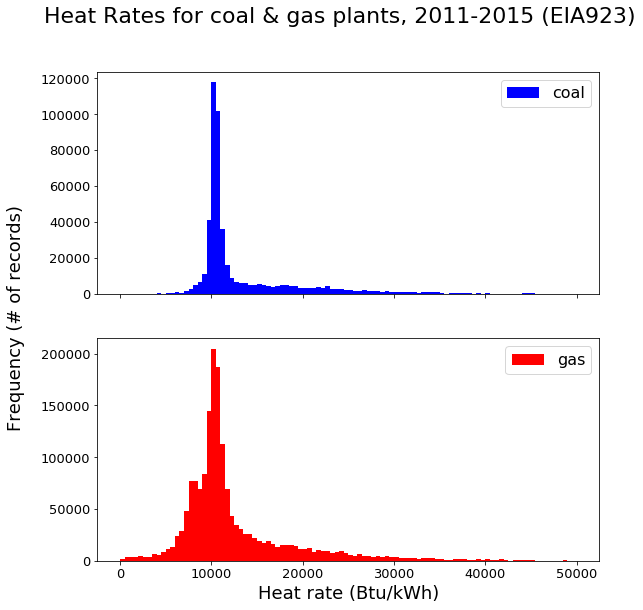

In [19]:
# Plot heat rate histogram for full data set by fuel type
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.hist(mwh_eia923_coal.calculated_heat_rate_btu_per_kwh, color= 'b', label='coal', range=(0,50000), bins=100)
ax1.legend(loc="upper right", fontsize=16)
ax1.yaxis.set_tick_params(labelsize=13)
ax2.hist(mwh_eia923_gas.calculated_heat_rate_btu_per_kwh, color= 'r', label='gas', range=(0,50000), bins=100)
ax2.legend(loc="upper right", fontsize=16)
plt.suptitle('Heat Rates for coal & gas plants, 2011-2015 (EIA923)', size=22)
ax2.set_xlabel('Heat rate (Btu/kWh)', size=18)
f.text(0.0, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', size=18)
f.set_size_inches(9,9)
plt.tick_params(axis='both', which='major', labelsize=13)
plt.show()

# Pull fuel_receipts_costs data from PUDL EIA923 tables


### Fuel_receipts_costs_eia923 gives info on heat content, fuel cost, and fuel purchase types

In [20]:
fuel_cost_eia923 = pd.read_sql('''SELECT plant_id, report_date, \
                                energy_source, fuel_group, contract_type, contract_expiration_date, coalmine_id, \
                                fuel_quantity, average_heat_content, average_sulfur_content \
                                average_ash_content, average_mercury_content, fuel_cost, primary_transportation_mode\
                                FROM fuel_receipts_costs_eia923 ''', pudl_engine)

### Can modify to change the variables pulled from the PostGres database to evaluate specific subsets of data

### Example that pulls fuel_receipts_costs_eia923 data just for the state of Colorado

In [21]:
# fuel_cost_eia923 = pd.read_sql('''SELECT plant_info_eia923.plant_state, fuel_receipts_costs_eia923.plant_id, \
#                                 report_date, energy_source, fuel_group, contract_type, contract_expiration_date, \
#                                 coalmine_id, fuel_quantity, average_heat_content, average_sulfur_content \
#                                 average_ash_content, average_mercury_content, fuel_cost, primary_transportation_mode \
#                                 FROM fuel_receipts_costs_eia923, plant_info_eia923 \
#                                 WHERE plant_info_eia923.plant_id = fuel_receipts_costs_eia923.plant_id \
#                                 AND plant_info_eia923.plant_state = 'CO' ''', pudl_engine)

In [22]:
# Looking at data at monthly scale, so creating both year and month fields
fuel_cost_eia923["report_date"] = pd.to_datetime(fuel_cost_eia923.report_date)
fuel_cost_eia923["year"] = fuel_cost_eia923["report_date"].dt.year
fuel_cost_eia923["month"] = fuel_cost_eia923["report_date"].dt.month

In [23]:
# Convert fuel costs from cents to dollars
fuel_cost_eia923['fuel_cost'] = fuel_cost_eia923['fuel_cost']/100

In [24]:
# Calculate heat_content_total by multiplying average_heat_content and fuel_quantity
fuel_cost_eia923["heat_content_total"] = (fuel_cost_eia923.average_heat_content*fuel_cost_eia923.fuel_quantity)

# # Calculate a monthly sum of fuel quantity & fuel content by fuel group and contract type
fuel_cost_eia923["monthly_fuel_quantity"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)
fuel_cost_eia923["monthly_heat_content"] = fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["heat_content_total"].transform(sum)

In [25]:
# Create purchase cost field, which is fuel_quantity * fuel_cost
fuel_cost_eia923["purchase_cost"] = (fuel_cost_eia923.fuel_cost*fuel_cost_eia923.fuel_quantity)

In [26]:
fuel_cost_eia923.tail(40)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost
325442,57482,2015-12-01,NG,Natural Gas,S,None,None,52645.0,1.048,0.0,0.0,NaN,PL,2015,12,55171.960,430405952.0,4.464960e+08,NaN
325443,57515,2015-12-01,NG,Natural Gas,T,None,None,306970.0,1.042,0.0,0.0,NaN,PL,2015,12,319862.740,83553562.0,8.610481e+07,NaN
325444,57664,2015-12-01,NG,Natural Gas,T,None,None,334663.0,1.031,0.0,0.0,NaN,PL,2015,12,345037.553,83553562.0,8.610481e+07,NaN
325445,57664,2015-12-01,NG,Natural Gas,T,None,None,325648.0,1.031,0.0,0.0,NaN,PL,2015,12,335743.088,83553562.0,8.610481e+07,NaN
325446,57664,2015-12-01,NG,Natural Gas,T,None,None,280646.0,1.031,0.0,0.0,NaN,PL,2015,12,289346.026,83553562.0,8.610481e+07,NaN
325447,57664,2015-12-01,NG,Natural Gas,T,None,None,30050.0,1.031,0.0,0.0,NaN,PL,2015,12,30981.550,83553562.0,8.610481e+07,NaN
325448,57664,2015-12-01,NG,Natural Gas,T,None,None,140735.0,1.031,0.0,0.0,NaN,PL,2015,12,145097.785,83553562.0,8.610481e+07,NaN
325449,57664,2015-12-01,NG,Natural Gas,T,None,None,84086.0,1.031,0.0,0.0,NaN,PL,2015,12,86692.666,83553562.0,8.610481e+07,NaN
325450,57664,2015-12-01,NG,Natural Gas,T,None,None,51221.0,1.031,0.0,0.0,NaN,PL,2015,12,52808.851,83553562.0,8.610481e+07,NaN
325451,57664,2015-12-01,NG,Natural Gas,T,None,None,259223.0,1.031,0.0,0.0,NaN,PL,2015,12,267258.913,83553562.0,8.610481e+07,NaN


In [27]:
# Create data frames by fuel_group for all data
coal = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Coal')]
gas = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Natural Gas')]
petroleum = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum')]
petcoke = fuel_cost_eia923[(fuel_cost_eia923.fuel_group == 'Petroleum_Coke')]

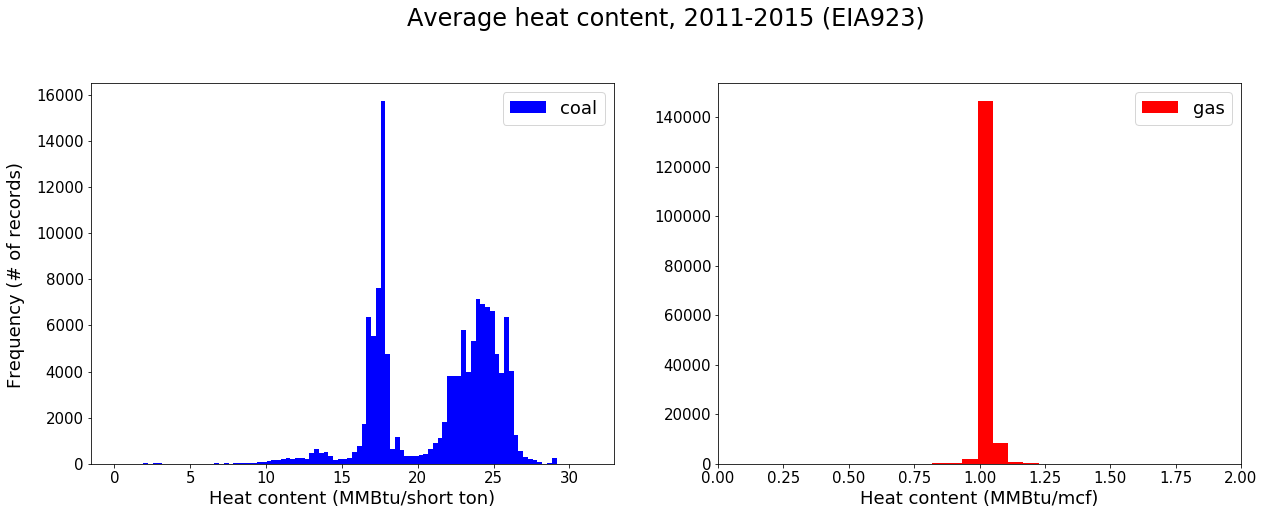

In [28]:
# Plot average heat content by fuel group
f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(coal.average_heat_content, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Heat content (MMBtu/short ton)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(gas.average_heat_content, color= 'r', label='gas', bins=100)
ax2.set_xlim(0,2)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Heat content (MMBtu/mcf)', size=18)
plt.text(-0.1, 1.2,'Average heat content, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)
plt.show()

### Fuel cost analysis

In [29]:
# Many records have NA fuel cost value, but have fuel quantity, heat content, etc. data
# Thus we only need to remove the NA values for the cost calculations
# Remove any negative or NA fuel cost values and call this 'positive_fuel'
positive_fuel = fuel_cost_eia923[fuel_cost_eia923['fuel_cost'] > 0]
# TODO: check to see how many records are being dropped
positive_fuel.fuel_cost.median()

3.661

In [30]:
positive_fuel.head(5)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,NaN,6.311,RV,2009,1,2889432.000,77258582.0,1.506515e+09,759800.223
1,3,2009-01-01,BIT,Coal,C,2013-12-01,None,199388.0,23.000,1.00,NaN,3.503,RV,2009,1,4585924.000,77258582.0,1.506515e+09,698456.164
2,3,2009-01-01,BIT,Coal,C,2013-12-01,None,43105.0,22.785,0.46,NaN,3.557,RV,2009,1,982147.425,77258582.0,1.506515e+09,153324.485
3,3,2009-01-01,BIT,Coal,C,2011-12-01,None,9458.0,23.790,1.00,NaN,4.980,RV,2009,1,225005.820,77258582.0,1.506515e+09,47100.840
4,3,2009-01-01,BIT,Coal,C,2009-12-01,None,9094.0,24.000,1.00,NaN,6.290,RV,2009,1,218256.000,77258582.0,1.506515e+09,57201.260


In [31]:
# Subset fuel_cost dataframes by fuel type
fuel_cost_coal = positive_fuel[(positive_fuel.fuel_group == 'Coal')]
fuel_cost_gas = positive_fuel[(positive_fuel.fuel_group == 'Natural Gas')]
fuel_cost_coal.shape

(94477, 19)

In [32]:
# Check maximum fuel cost for natural gas (in $)
fuel_cost_gas.fuel_cost.max()

235381.13

In [33]:
# Check maximum fuel cost for coal (in $)
fuel_cost_coal.fuel_cost.max()

32.670000000000002

In [34]:
# Natural gas fuel costs have high values that are unrealistic 
# Separate the values that are over $50/MMBtu
fuel_cost_gas_high = fuel_cost_gas[fuel_cost_gas['fuel_cost'] >50]
fuel_cost_gas = fuel_cost_gas[fuel_cost_gas['fuel_cost'] <=50]
fuel_cost_gas.fuel_cost.max()

49.725000000000001

In [35]:
# How many natural gas records exceed $50/MMBtu?
fuel_cost_gas_high.shape

(610, 19)

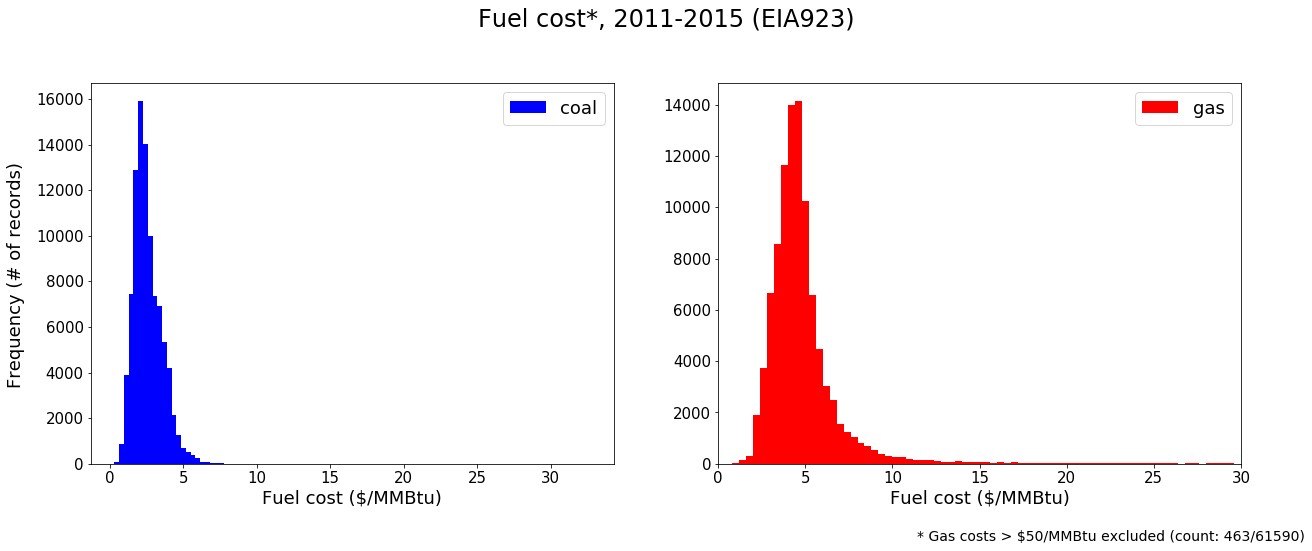

In [36]:
# Plot fuel cost per MMBtu by fuel group

f, (ax1, ax2) = plt.subplots(1, 2)
ax1.hist(fuel_cost_coal.fuel_cost, color='b', label='coal', bins=100)
ax1.legend(loc="upper right", fontsize=18)
ax1.set_xlabel('Fuel cost ($/MMBtu)', size=18)
ax1.yaxis.set_tick_params(labelsize=15)
ax1.xaxis.set_tick_params(labelsize=15)
ax2.hist(fuel_cost_gas.fuel_cost, color= 'r', label='gas', range=(0,40), bins=100)
ax2.set_xlim(0,30)
ax2.legend(loc="upper right", fontsize=18)
ax2.set_xlabel('Fuel cost ($/MMBtu)', size=18)
plt.text(-0.1, 1.2,'Fuel cost*, 2011-2015 (EIA923)', ha='center', 
         va='top', transform=ax2.transAxes, fontsize=24)
plt.tick_params(axis='both', which='major', labelsize=15)
f.subplots_adjust(left=None, bottom=None, right=1.9, top=None, wspace=None, hspace=None)
f.set_size_inches(9,7)
f.text(.01, 0.5, 'Frequency (# of records)', ha='center', va='center', rotation='vertical', fontsize=18)

f.text(1.7, -0.02, '* Gas costs > $50/MMBtu excluded (count: 463/61590)', ha='center', va='center', fontsize=14)
plt.show()

### Look at fuel data by contract type
### Calculating monthly averages and sums means individual records are lost and other fields should not be used (TODO: remove the non-monthly data columns when monthly values are calculated)

In [37]:
# Monthly averages use variable divided by total fuel quantity for weighted monthly averages by fuel group & contract type 
# Other monthly fields (monthly_fuel_quantity & monthly_purchase_cost) are summed by fuel group & contract type
# fuel_cost_eia923 dataframe is used for non-cost-related data
# positve_fuel dataframe is used for cost-related data
fuel_cost_eia923["monthly_average_heat_content"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["heat_content_total"].transform(sum))/(fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
fuel_cost_eia923["monthly_fuel_quantity"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
fuel_cost_eia923["monthly_purchase_cost"] = ((fuel_cost_eia923.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum)))
positive_fuel["monthly_average_fuel_cost"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum))/(positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
positive_fuel["monthly_fuel_quantity"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["fuel_quantity"].transform(sum)))
positive_fuel["monthly_purchase_cost"] = ((positive_fuel.groupby(["year", "month", "fuel_group", "contract_type"])["purchase_cost"].transform(sum)))

# Drop duplicates of monthly sums/averages, so we lose indvidual purchase records but retain monthly data by fuel group & contract type
fuel_cost_eia923 = fuel_cost_eia923.drop_duplicates(subset=['report_date', 'fuel_group', 'contract_type'])
positive_fuel = positive_fuel.drop_duplicates(subset=['report_date', 'fuel_group', 'contract_type'])

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [38]:
# Look at non-cost data
fuel_cost_eia923.head(6)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,...,6.311,RV,2009,1,2889432.000,77258582.0,1.506515e+09,7.598002e+05,19.499641,1.096186e+08
5,3,2009-01-01,NG,Natural Gas,C,None,None,1902799.0,1.036,0.00,...,6.809,PL,2009,1,1971299.764,279171727.0,2.868464e+08,1.295616e+07,1.027491,6.502393e+08
7,7,2009-01-01,BIT,Coal,S,None,None,21205.0,24.908,1.66,...,3.976,TR,2009,1,528174.140,7237311.0,1.525622e+08,8.431108e+04,21.079951,1.686263e+07
8,7,2009-01-01,NG,Natural Gas,S,None,None,3189.0,1.014,0.00,...,6.381,None,2009,1,3233.646,275119957.0,2.826262e+08,2.034901e+04,1.027284,7.643532e+08
32,8,2009-01-01,DFO,Petroleum,C,None,None,362.0,5.875,0.07,...,11.823,TR,2009,1,2126.750,4730642.0,2.937624e+07,4.279926e+03,6.209778,2.639200e+07
45,47,2009-01-01,BIT,Coal,NC,None,None,26636.0,24.870,0.80,...,3.897,RV,2009,1,662437.320,1814457.0,3.845251e+07,1.038005e+05,21.192295,5.238491e+06


In [39]:
# Look at cost-related data
positive_fuel.head(6)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_fuel_cost,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,...,6.311,RV,2009,1,2889432.000,54504798.0,1.506515e+09,7.598002e+05,2.011173,1.096186e+08
5,3,2009-01-01,NG,Natural Gas,C,None,None,1902799.0,1.036,0.00,...,6.809,PL,2009,1,1971299.764,81127323.0,2.868464e+08,1.295616e+07,8.015047,6.502393e+08
7,7,2009-01-01,BIT,Coal,S,None,None,21205.0,24.908,1.66,...,3.976,TR,2009,1,528174.140,5691803.0,1.525622e+08,8.431108e+04,2.962617,1.686263e+07
8,7,2009-01-01,NG,Natural Gas,S,None,None,3189.0,1.014,0.00,...,6.381,None,2009,1,3233.646,119411525.0,2.826262e+08,2.034901e+04,6.401001,7.643532e+08
32,8,2009-01-01,DFO,Petroleum,C,None,None,362.0,5.875,0.07,...,11.823,TR,2009,1,2126.750,3577625.0,2.937624e+07,4.279926e+03,7.376962,2.639200e+07
45,47,2009-01-01,BIT,Coal,NC,None,None,26636.0,24.870,0.80,...,3.897,RV,2009,1,662437.320,1717279.0,3.845251e+07,1.038005e+05,3.050460,5.238491e+06


In [40]:
# Monthly records for coal purchased by contract or new contract
contract_buy_coal = fuel_cost_eia923[((fuel_cost_eia923.contract_type == 'C')|(fuel_cost_eia923.contract_type == 'NC')) & (fuel_cost_eia923.fuel_group == 'Coal')]
contract_buy_coal.head(2)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.00,1.0,...,6.311,RV,2009,1,2889432.00,77258582.0,1.506515e+09,759800.223,19.499641,1.096186e+08
45,47,2009-01-01,BIT,Coal,NC,None,None,26636.0,24.87,0.8,...,3.897,RV,2009,1,662437.32,1814457.0,3.845251e+07,103800.492,21.192295,5.238491e+06


In [41]:
#merge contracts and new contracts into the same category for fields of interest
contract_buy_coal["monthly_fuel_quantity"] = contract_buy_coal.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_coal["monthly_heat_content"] = contract_buy_coal.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_coal["monthly_average_heat_content"] = ((contract_buy_coal.groupby(["report_date"])["monthly_heat_content"].transform(sum))/(contract_buy_coal.groupby(["report_date"])["fuel_quantity"].transform(sum)))
contract_buy_coal = contract_buy_coal.drop_duplicates(subset=['report_date'])
contract_buy_coal.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(84, 21)

In [42]:
contract_buy_coal.head(6)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,...,6.311,RV,2009,1,2889432.000,79073039.0,1.544967e+09,759800.223,21015.814954,1.096186e+08
5389,3,2009-02-01,BIT,Coal,C,2009-12-01,None,30647.0,23.514,0.50,...,8.236,RV,2009,2,720633.558,74598520.0,1.472757e+09,252408.692,74624.782738,1.124558e+08
10509,3,2009-03-01,BIT,Coal,C,2013-12-01,None,174390.0,22.545,0.40,...,3.503,RV,2009,3,3931622.550,77253869.0,1.547687e+09,610888.170,12885.579083,1.195821e+08
15629,3,2009-04-01,BIT,Coal,C,2009-12-01,None,12756.0,25.536,0.49,...,5.219,RV,2009,4,325737.216,71620285.0,1.434752e+09,66573.564,152885.287462,1.124493e+08
20478,3,2009-05-01,BIT,Coal,C,2013-12-01,None,89129.0,22.524,0.58,...,3.421,RV,2009,5,2007541.596,73551164.0,1.461723e+09,304910.309,27098.802347,1.140807e+08
25341,3,2009-06-01,BIT,Coal,C,2013-12-01,None,289436.0,22.666,0.70,...,3.497,RV,2009,6,6560356.376,73183136.0,1.455737e+09,1012157.692,9465.652013,1.148550e+08


In [43]:
# Monthly records of costs for coal purchased by contract or new contract
contract_buy_coal_costs = positive_fuel[((positive_fuel.contract_type == 'C')|(positive_fuel.contract_type == 'NC')) & (positive_fuel.fuel_group == 'Coal')]
contract_buy_coal_costs.head(6)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_fuel_cost,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,...,6.311,RV,2009,1,2889432.000,54504798.0,1.506515e+09,759800.223,2.011173,1.096186e+08
45,47,2009-01-01,BIT,Coal,NC,None,None,26636.0,24.870,0.80,...,3.897,RV,2009,1,662437.320,1717279.0,3.845251e+07,103800.492,3.050460,5.238491e+06
5389,3,2009-02-01,BIT,Coal,C,2009-12-01,None,30647.0,23.514,0.50,...,8.236,RV,2009,2,720633.558,53334707.0,1.471183e+09,252408.692,2.108491,1.124558e+08
6460,1843,2009-02-01,SUB,Coal,NC,2009-01-01,None,8824.0,18.600,0.31,...,2.526,GL,2009,2,164126.400,84950.0,1.573901e+06,22289.424,2.673840,2.271427e+05
10509,3,2009-03-01,BIT,Coal,C,2013-12-01,None,174390.0,22.545,0.40,...,3.503,RV,2009,3,3931622.550,55948042.0,1.542115e+09,610888.170,2.137377,1.195821e+08
10552,47,2009-03-01,BIT,Coal,NC,2009-03-01,None,65830.0,21.250,0.40,...,2.525,RR,2009,3,1398887.500,187151.0,5.572273e+06,166220.750,2.379059,4.452433e+05


In [44]:
#merge contracts and new contracts into the same category
contract_buy_coal_costs["monthly_heat_content"] = contract_buy_coal_costs.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_coal_costs["monthly_average_fuel_cost"] = ((contract_buy_coal_costs.groupby(["report_date"])["monthly_purchase_cost"].transform(sum))/(contract_buy_coal_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)))
contract_buy_coal_costs["monthly_fuel_quantity"] = contract_buy_coal_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_coal_costs = contract_buy_coal_costs.drop_duplicates(subset=['report_date'])
contract_buy_coal_costs.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(84, 21)

In [45]:
# #merge contracts and new contracts into the same category for both monthly_average_fuel_cost column
# contract_buy_coal_costs["monthly_fuel_quantity"] = contract_buy_coal_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_coal_costs.head(6)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_fuel_cost,monthly_purchase_cost
0,3,2009-01-01,BIT,Coal,C,2009-12-01,None,120393.0,24.000,1.00,...,6.311,RV,2009,1,2889432.000,56222077.0,1.544967e+09,759800.223,2.042917,1.096186e+08
5389,3,2009-02-01,BIT,Coal,C,2009-12-01,None,30647.0,23.514,0.50,...,8.236,RV,2009,2,720633.558,53419657.0,1.472757e+09,252408.692,2.109390,1.124558e+08
10509,3,2009-03-01,BIT,Coal,C,2013-12-01,None,174390.0,22.545,0.40,...,3.503,RV,2009,3,3931622.550,56135193.0,1.547687e+09,610888.170,2.138183,1.195821e+08
15629,3,2009-04-01,BIT,Coal,C,2009-12-01,None,12756.0,25.536,0.49,...,5.219,RV,2009,4,325737.216,53408268.0,1.434752e+09,66573.564,2.113046,1.124493e+08
20478,3,2009-05-01,BIT,Coal,C,2013-12-01,None,89129.0,22.524,0.58,...,3.421,RV,2009,5,2007541.596,54346459.0,1.461723e+09,304910.309,2.105691,1.140807e+08
25341,3,2009-06-01,BIT,Coal,C,2013-12-01,None,289436.0,22.666,0.70,...,3.497,RV,2009,6,6560356.376,54571475.0,1.455737e+09,1012157.692,2.106425,1.148550e+08


In [46]:
# Monthly records for natural gas purchased by contract or new contract
contract_buy_gas = fuel_cost_eia923[((fuel_cost_eia923.contract_type == 'C')|(fuel_cost_eia923.contract_type == 'NC')) & (fuel_cost_eia923.fuel_group == 'Natural Gas')]
contract_buy_gas.head(1)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
5,3,2009-01-01,NG,Natural Gas,C,None,None,1902799.0,1.036,0.0,...,6.809,PL,2009,1,1971299.764,279171727.0,2.868464e+08,1.295616e+07,1.027491,6.502393e+08


In [47]:
#merge contracts and new contracts into the same category
contract_buy_gas["monthly_heat_content"] = contract_buy_gas.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_gas["monthly_fuel_quantity"] = contract_buy_gas.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_gas["monthly_average_heat_content"] = contract_buy_gas.groupby(["report_date"])["monthly_average_heat_content"].transform(sum)
contract_buy_gas = contract_buy_gas.drop_duplicates(subset=['report_date'])

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

In [48]:
contract_buy_gas.tail(1)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
322887,96,2015-12-01,NG,Natural Gas,NC,2015-12-01,None,172366.0,1.0,0.0,...,2.66,PL,2015,12,172366.0,277738189.0,2.859989e+08,458493.56,2.041064,3146220.699


In [49]:
# Monthly records of costs for natural gas purchased by contract or new contract
contract_buy_gas_costs = positive_fuel[((positive_fuel.contract_type == 'C')|(positive_fuel.contract_type == 'NC')) & (positive_fuel.fuel_group == 'Natural Gas')]
contract_buy_gas_costs.head(2)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_fuel_cost,monthly_purchase_cost
5,3,2009-01-01,NG,Natural Gas,C,None,None,1902799.0,1.036,0.0,...,6.809,PL,2009,1,1971299.764,81127323.0,2.868464e+08,1.295616e+07,8.015047,6.502393e+08
2214,3559,2009-01-01,NG,Natural Gas,NC,2012-03-01,None,51972.0,1.046,0.0,...,5.704,None,2009,1,54362.712,71052.0,4.247775e+05,2.964483e+05,5.308008,3.771446e+05


In [50]:
#merge contracts and new contracts into the same category
contract_buy_gas_costs["monthly_heat_content"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_heat_content"].transform(sum)
contract_buy_gas_costs["monthly_fuel_quantity"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_fuel_quantity"].transform(sum)
contract_buy_gas_costs["monthly_average_fuel_cost"] = contract_buy_gas_costs.groupby(["report_date"])["monthly_average_fuel_cost"].transform(sum)
contract_buy_gas_costs = contract_buy_gas_costs.drop_duplicates(subset=['report_date'])
contract_buy_gas_costs.shape

/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/alana/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats

(84, 21)

In [51]:
# Monthly records for spot purchases of coal
spot_buy_coal = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Coal')]
spot_buy_coal.shape

(84, 21)

In [52]:
# Monthly records of costs for spot purchases of coal
spot_buy_coal_costs = positive_fuel[(positive_fuel.contract_type == 'S') & (positive_fuel.fuel_group == 'Coal')]
spot_buy_coal_costs.head(5)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_fuel_cost,monthly_purchase_cost
7,7,2009-01-01,BIT,Coal,S,None,None,21205.0,24.908,1.66,...,3.976,TR,2009,1,528174.140,5691803.0,1.525622e+08,84311.080,2.962617,1.686263e+07
5396,7,2009-02-01,BIT,Coal,S,None,None,21237.0,24.908,1.66,...,3.916,TR,2009,2,528971.196,4591243.0,1.317741e+08,83164.092,2.884393,1.324295e+07
10515,7,2009-03-01,BIT,Coal,S,None,None,22619.0,24.908,1.66,...,3.584,TR,2009,3,563394.052,5998205.0,1.608111e+08,81066.496,2.616828,1.569627e+07
15635,7,2009-04-01,BIT,Coal,S,None,None,15883.0,24.908,1.66,...,3.184,TR,2009,4,395613.764,6719579.0,1.568491e+08,50571.472,2.259950,1.518591e+07
20484,7,2009-05-01,BIT,Coal,S,None,None,19756.0,24.908,1.66,...,3.388,TR,2009,5,492082.448,4786105.0,1.215848e+08,66933.328,2.437716,1.166716e+07


In [53]:
# Monthly records for spot purchases of natural gas
spot_buy_gas = fuel_cost_eia923[(fuel_cost_eia923.contract_type == 'S') & (fuel_cost_eia923.fuel_group == 'Natural Gas')]

In [54]:
# Monthly records of costs for spot purchases of natural gas
spot_buy_gas_costs = positive_fuel[(positive_fuel.contract_type == 'S') & (positive_fuel.fuel_group == 'Natural Gas')]

In [55]:
spot_buy_gas.head(2)

,plant_id,report_date,energy_source,fuel_group,contract_type,contract_expiration_date,coalmine_id,fuel_quantity,average_heat_content,average_ash_content,...,fuel_cost,primary_transportation_mode,year,month,heat_content_total,monthly_fuel_quantity,monthly_heat_content,purchase_cost,monthly_average_heat_content,monthly_purchase_cost
8,7,2009-01-01,NG,Natural Gas,S,None,None,3189.0,1.014,0.0,...,6.381,None,2009,1,3233.646,275119957.0,2.826262e+08,20349.009,1.027284,7.643532e+08
5397,7,2009-02-01,NG,Natural Gas,S,None,None,1.0,1.024,0.0,...,5.792,None,2009,2,1.024,262297731.0,2.692923e+08,5.792,1.026666,6.441265e+08


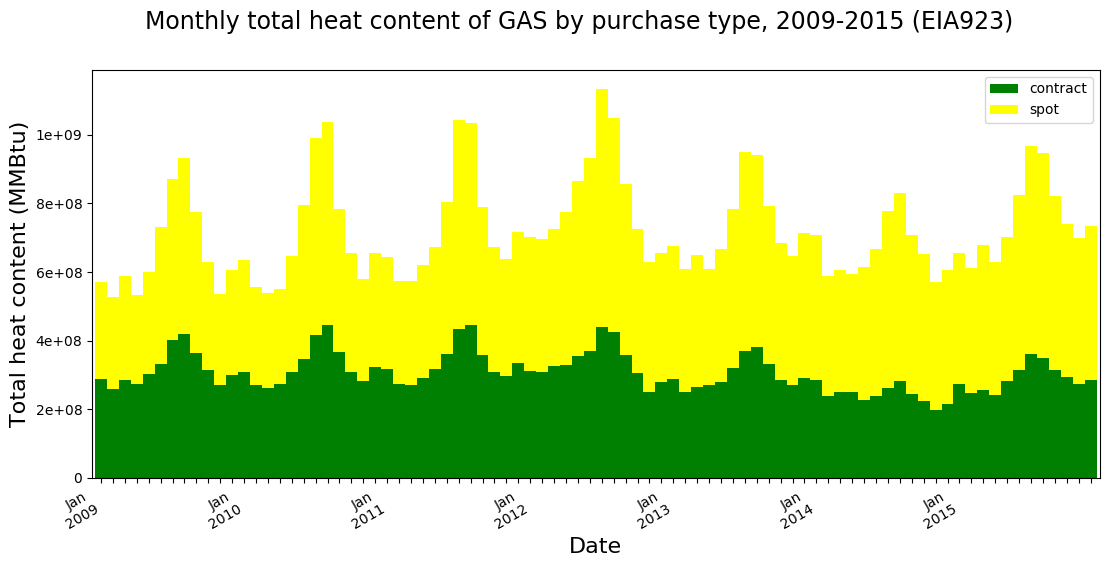

In [56]:
# Plot monthly total heat content for natural gas by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_gas.monthly_heat_content.plot(kind='bar', x=contract_buy_gas.report_date, width=1.0, stacked=True, color='green', label='contract')
p2 = spot_buy_gas.monthly_heat_content.plot(kind='bar', x=spot_buy_gas.report_date, width=1.0, stacked=True, bottom=contract_buy_gas.monthly_heat_content, color='yellow', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_gas.index)
# Every 4th ticklable shows the month and/or day
# ticklabels[::4] = [item.strftime('%b %d') for item in contract_buy_coal.report_date[::12]] #shows month and day
# ticklabels[::4] = [item.strftime('%b') for item in contract_buy_coal.report_date[::12]] #shows month

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_gas.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total heat content (MMBtu)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total heat content of GAS by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

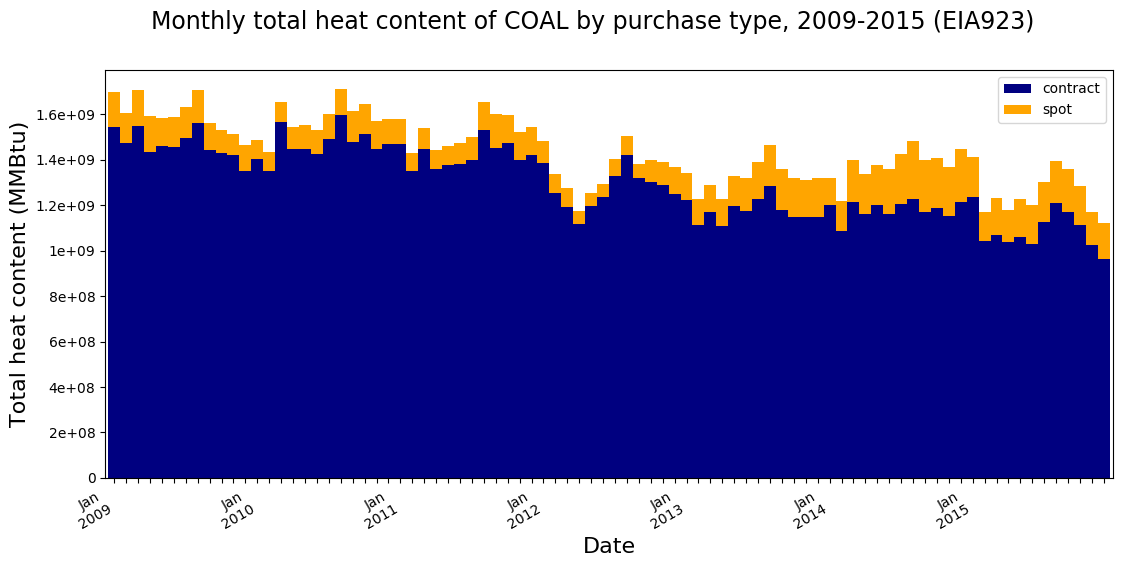

In [57]:
# Plot monthly total heat content for coal by contract type

fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_coal.monthly_heat_content.plot(kind='bar', x=contract_buy_coal.report_date, width=1.0, stacked=True, colormap='jet', label='contract')
p2 = spot_buy_coal.monthly_heat_content.plot(kind='bar', x=contract_buy_coal.report_date,  width=1.0,stacked=True, bottom=contract_buy_coal.monthly_heat_content, color='orange', label='spot')
contract_buy_coal.heat_content_total.plot

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total heat content (MMBtu)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total heat content of COAL by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

In [58]:
# To calculate proportional purchases, create two new data frames - one each for contract and spot purchases
dfc = pd.concat([contract_buy_coal['monthly_heat_content'], contract_buy_coal['report_date']], axis=1, keys=['contract', 'date'])
dfs = pd.concat([spot_buy_coal['monthly_heat_content'], spot_buy_coal['report_date']], axis=1, keys=['spot', 'date'])

In [59]:
dfs.head(2)

,spot,date
7,1.525622e+08,2009-01-01
5396,1.317741e+08,2009-02-01


In [60]:
# Create merged dataframe of contract and spot purchase total heat contents
sum = pd.merge(dfc, dfs, on='date')

In [61]:
sum.head(2)

,contract,date,spot
0,1.544967e+09,2009-01-01,1.525622e+08
1,1.472757e+09,2009-02-01,1.317741e+08


In [62]:
# Add contract and spot heat contents together
heat_sum = sum.contract+sum.spot

In [63]:
# Calculate percentages
contract_heat_percent = (sum.contract/heat_sum)*100
spot_heat_percent = (sum.spot/heat_sum)*100

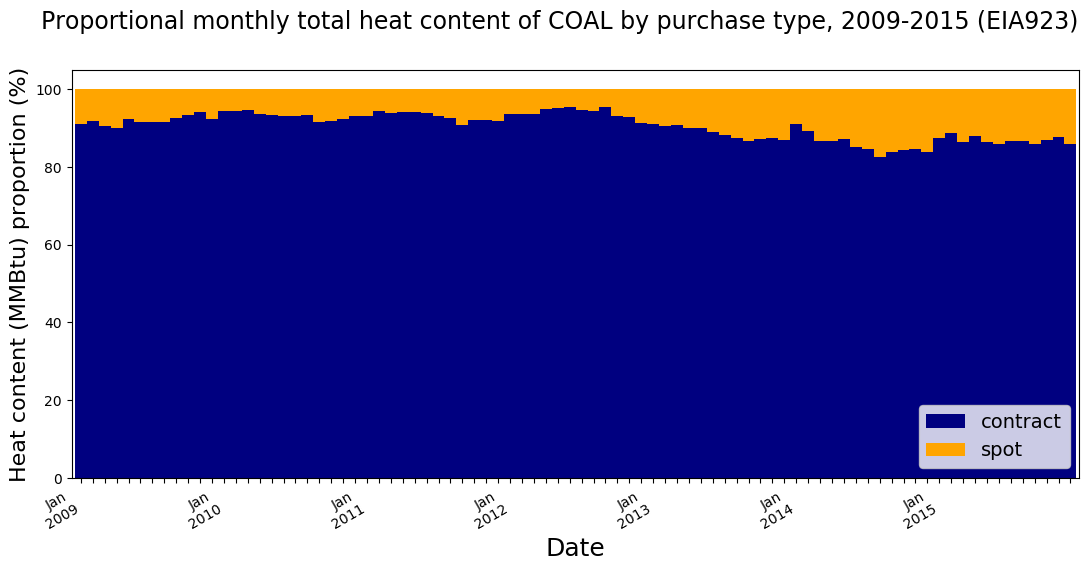

In [64]:
# Plot proportional heat content of coal purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_heat_percent.plot(kind='bar', x=contract_buy_coal.report_date, width=1.0, stacked=True, colormap='jet', label='contract')
p2 = spot_heat_percent.plot(kind='bar', x=spot_buy_coal.report_date,  width=1.0,stacked=True, bottom=contract_heat_percent, color='orange', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Heat content (MMBtu) proportion (%)', size=16)
ax.set_xlabel('Date', size=18)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1, 0), loc='lower right', ncol=1, fontsize=14)
plt.suptitle('Proportional monthly total heat content of COAL by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

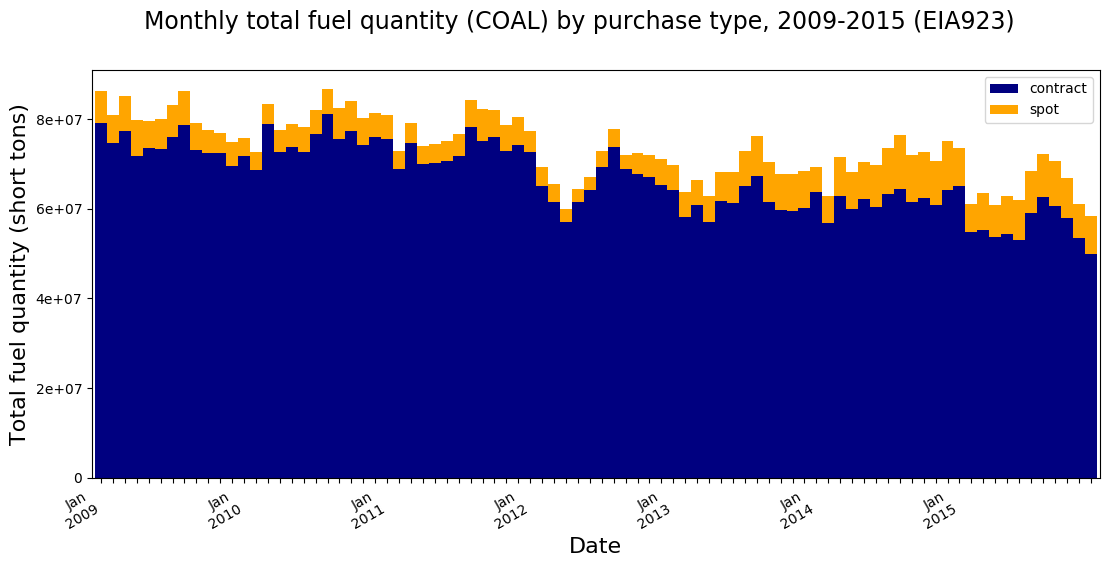

In [65]:
# Plot total fuel quantity of coal purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_coal.monthly_fuel_quantity.plot(kind='bar', width=1.0, x=contract_buy_coal.report_date, stacked=True, colormap='jet', label='contract')
p2 = spot_buy_coal.monthly_fuel_quantity.plot(kind='bar', width=1.0, x=contract_buy_coal.report_date, stacked=True, bottom=contract_buy_coal.monthly_fuel_quantity, color='orange', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total fuel quantity (short tons)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total fuel quantity (COAL) by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

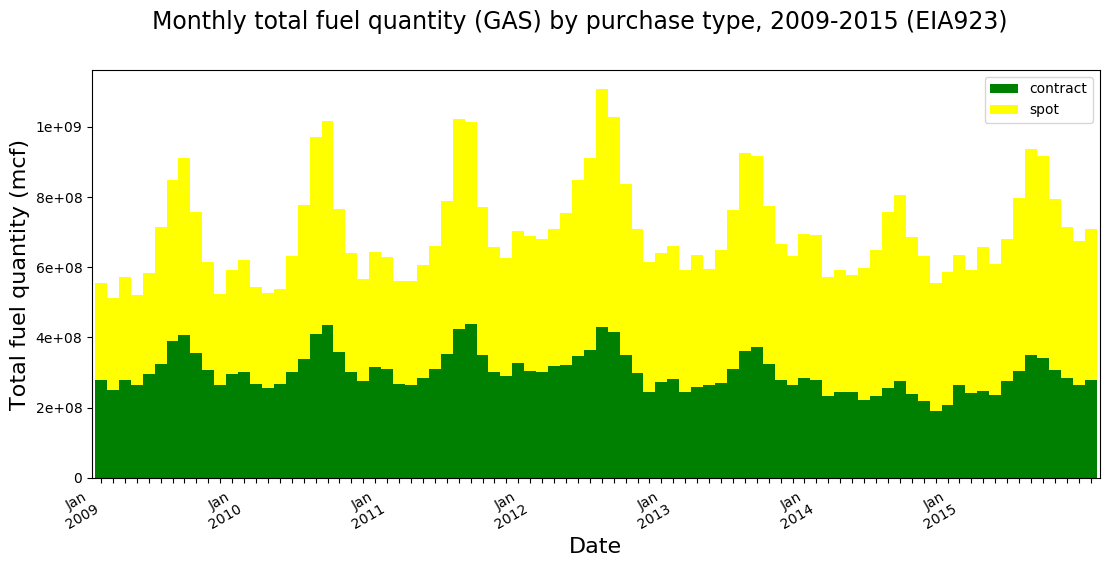

In [66]:
# Plot total fuel quantity of natural gas purchases by contract type
fig = plt.figure(figsize=(13,6), dpi=100)
ax = plt.subplot(111)
p1 = contract_buy_gas.monthly_fuel_quantity.plot(kind='bar',  width=1.0, x=contract_buy_gas.report_date, stacked=True, color='green', label='contract')
p2 = spot_buy_gas.monthly_fuel_quantity.plot(kind='bar',  width=1.0, x=contract_buy_gas.report_date, stacked=True, bottom=contract_buy_gas.monthly_fuel_quantity, color='yellow', label='spot')

# Make most of the ticklabels empty so the labels don't get too crowded
ticklabels = ['']*len(contract_buy_coal.index)

# Every 12th ticklabel includes the year
ticklabels[::12] = [item.strftime('%b \n%Y') for item in contract_buy_coal.report_date[::12]] #shows month, year
ax.xaxis.set_major_formatter(ticker.FixedFormatter(ticklabels))
ax.set_ylabel('Total fuel quantity (mcf)', size=16)
ax.set_xlabel('Date', size=16)
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.suptitle('Monthly total fuel quantity (GAS) by purchase type, 2009-2015 (EIA923)', size=17)
plt.show()

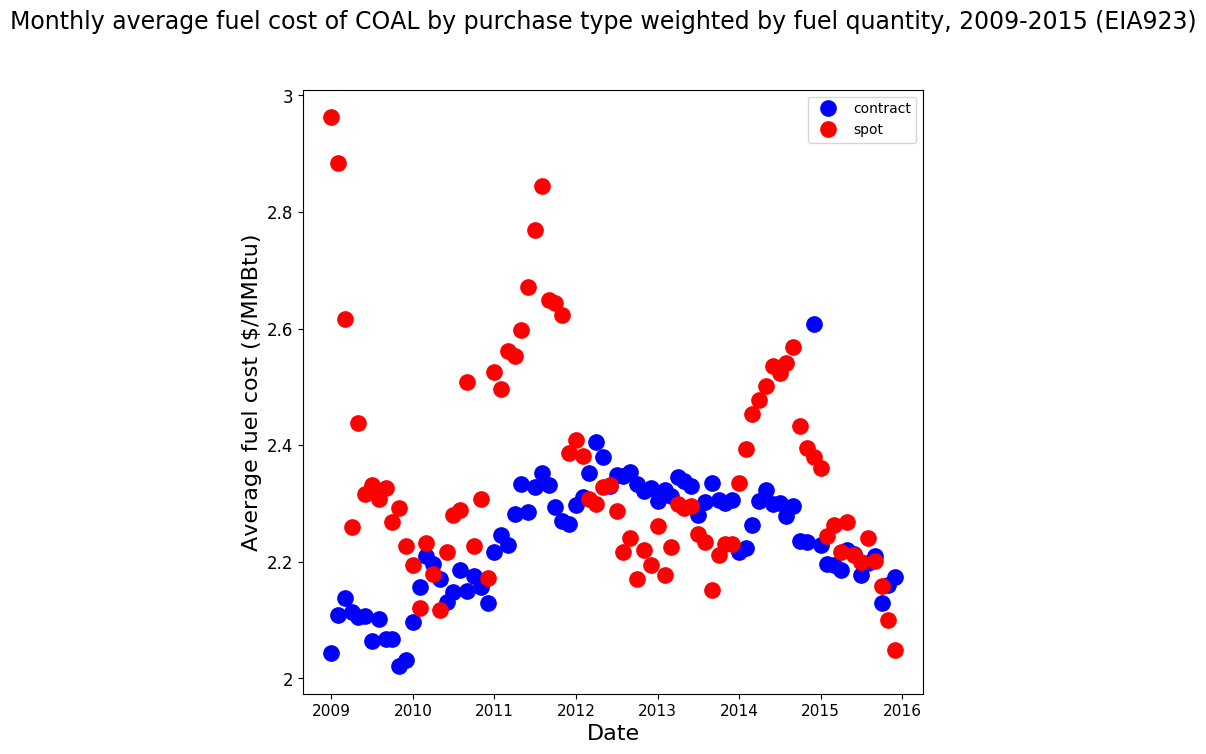

In [67]:
# Plot monthly fuel cost per MMBtu for coal by contract type

fig = plt.figure(figsize=(8, 8), dpi=100)
plt.plot_date(x=contract_buy_coal_costs.report_date, y=contract_buy_coal_costs.monthly_average_fuel_cost, marker='o', markersize = 11, color='b', label="contract")
plt.ylabel('Average fuel cost ($/MMBtu)', size=16)
plt.xlabel('Date', size=16)
plt.plot_date(x=spot_buy_coal_costs.report_date, y=spot_buy_coal_costs.monthly_average_fuel_cost, marker='o', markersize=11, color='r', label="spot")
plt.legend()
from matplotlib.ticker import FormatStrFormatter
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%g'))
plt.xticks(size=11)
plt.yticks(size=12)
plt.suptitle('Monthly average fuel cost of COAL by purchase type weighted by fuel quantity, 2009-2015 (EIA923)', size=17)
plt.show()

In [68]:
contract_buy_coal_costs.monthly_average_fuel_cost.min()

2.0206724060212018

In [69]:
contract_buy_coal_costs.monthly_average_fuel_cost.max()

2.607229603592601

In [70]:
spot_buy_coal_costs.monthly_average_fuel_cost.min()

2.0489773388134331

In [71]:
spot_buy_coal_costs.monthly_average_fuel_cost.max()

2.9626172581869024